3/27/25

Goal: Compare models and generate figures for Boston Symmetry Day poster w/ Moritz+Saumya

Figures of interest: 
* 1st epoch optimizer losses on retraining vs random initialization
* Multiple epoch comparison of retrained vs random initialization
* Scatter showing the input test score (%) vs the recon test score (%)

In [1]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.optim import Adam, SGD
from collections import defaultdict
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# torch.backends.cudnn.enabled = False

cpu


In [2]:
# Define the transform to downsample the images to 14x14 pixels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define MNIST classifier MLP class for dataset
# changed 2/13 to add dropout regularization - yet to retrain dataset
# 
# Define MNIST classifier MLP class for dataset
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None, use_dropout = False):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(196, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(p = 0.20) # example, aggressive dropout probability
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        if not self.use_dropout:
            x = x.view(-1, 196)
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
        else: 
            x = x.view(-1, 196)
            x = torch.relu( self.dropout(self.fc1(x)) )
            x = torch.relu( self.dropout(self.fc2(x)) )
            x = self.fc3(x)
        return x

    
def test_mlp(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()


In [3]:
# Functions for permutations and weight matching
def permute_layer_weights(layer, perm):
    """Permutes weights and biases of a layer based on the given permutation matrix."""
    weight = layer.weight.data.clone()
    bias = layer.bias.data.clone()

    # Permute rows of weights (output dimension)
    layer.weight.data = weight[perm, :]

    # Permute bias (output dimension)
    layer.bias.data = bias[perm]
    return layer

def permute_model(model, permutations):
    """Applies a list of permutations to a model's layers."""
    permute_layer_weights(model.fc1, permutations[0])
    permute_layer_weights(model.fc2, permutations[1])

    # Adjust input weights of the second hidden layer
    model.fc2.weight.data = model.fc2.weight.data[:, permutations[0]]
    # Adjust input weights of the output layer
    model.fc3.weight.data = model.fc3.weight.data[:, permutations[1]]
    return model

# Functions to permute weights and adjust input weights
def apply_permutation(layer, perm):
    """
    Applies the given permutation to the weights and biases of a layer.
    Args:
        layer: The layer to permute.
        perm: The permutation array.
    """
    # Permute rows (output dimension) of weights
    layer.weight.data = layer.weight.data[perm, :]
    # Permute biases
    layer.bias.data = layer.bias.data[perm]

def adjust_input_weights(layer, perm):
    """
    Adjusts the input wei
    ghts of a layer according to the permutation of the previous layer.
    Args:
        layer: The layer to adjust.
        perm: The permutation array of the previous layer.
    """
    layer.weight.data = layer.weight.data[:, perm]
    
def generate_permutation_matrix(hidden_dim):
    """Generates a random permutation matrix."""
    perm = np.random.permutation(hidden_dim)
    return torch.tensor(perm, dtype=torch.long)

def compute_similarity_matrix(weights_a, weights_b):
    """
    Computes the similarity matrix for two layers' weights.
    """
    weights_a = weights_a.view(weights_a.size(0), -1)
    weights_b = weights_b.view(weights_b.size(0), -1)
    return torch.matmul(weights_a, weights_b.T)

def get_permuted_weights(weights, perm):
    """
    Permutes the rows of weights based on the given permutation.
    """
    return weights[perm, :]


def weight_matching(rng, model_a, model_b, max_iter=100, init_perm=None):
    """
    Optimizes permutations to match Model B to Model A.
    """
    layers = ['fc1', 'fc2', 'fc3']
    perm_sizes = {layer: getattr(model_a, layer).weight.size(0) for layer in layers[:-1]}
    perm = {layer: np.arange(size) for layer, size in perm_sizes.items()} if init_perm is None else init_perm

    for iteration in range(max_iter):
        progress = False
        for layer in layers[:-1]:  # Exclude the output layer (fc3)
            n = perm_sizes[layer]
            similarity_matrix = compute_similarity_matrix(
                getattr(model_a, layer).weight.data,
                get_permuted_weights(getattr(model_b, layer).weight.data, perm[layer])
            )
            row_ind, col_ind = linear_sum_assignment(similarity_matrix.numpy(), maximize=True)

            old_score = np.sum(similarity_matrix.numpy()[np.arange(n), perm[layer]])
            new_score = np.sum(similarity_matrix.numpy()[np.arange(n), col_ind])

            if new_score > old_score:
                perm[layer] = col_ind
                progress = True

        if not progress:
            break

    return perm, new_score

def rebase_model_b_to_a(rng, model_a, model_b, max_iter=100):
    """
    Rebases Model B to match Model A using weight matching.
    """
    # Generate initial permutations
    init_perm = {layer: generate_permutation_matrix(getattr(model_a, layer).weight.size(0)) for layer in ['fc1', 'fc2']}
    
    # Perform weight matching
    permutations, score = weight_matching(rng, model_a, model_b, max_iter=max_iter, init_perm=init_perm)
    
    # Apply the permutations to Model B
    model_b = permute_model(model_b, [permutations['fc1'], permutations['fc2']])
    
    return model_b, permutations, score

def load_model_weights(model, weight_path):
    # Load weights and biases
    weights, biases = torch.load(weight_path)
    model.fc1.weight.data = weights[0]
    model.fc2.weight.data = weights[1]
    model.fc3.weight.data = weights[2]
    model.fc1.bias.data = biases[0]
    model.fc2.bias.data = biases[1]
    model.fc3.bias.data = biases[2]
    return model

def reconstruct_model(model, final_permutations):
    """
    Reconstruct model_b by applying the final permutations to its layers.
    Args:
        model_b (MLP): The model to be reconstructed.
        final_permutations (dict): Dictionary containing layer-wise permutations.
    Returns:
        MLP: The reconstructed model.
    """
    # Apply permutations to fc1 layer
    apply_permutation(model.fc1, final_permutations[1]['fc1'])
    adjust_input_weights(model.fc2, final_permutations[1]['fc1'])
    
    # Apply permutations to fc2 layer
    apply_permutation(model.fc2, final_permutations[1]['fc2'])
    adjust_input_weights(model.fc3, final_permutations[1]['fc2'])
    
    # Return the reconstructed model
    return model

def extract_weights_and_biases(model):
    """Flatten the weights and biases of each layer in the model into a single vector."""
    all_weights_biases = []
    
    # Flatten weights and biases for each layer
    for layer_name in ['fc1', 'fc2', 'fc3']:
        weights = getattr(model, layer_name).weight.data.numpy().flatten()  # Flatten the weights
        biases = getattr(model, layer_name).bias.data.numpy().flatten()    # Flatten the biases
        all_weights_biases.extend(weights)
        all_weights_biases.extend(biases)
    
    return np.array(all_weights_biases)

import time

def get_permuted_models_data(ref_point=0, N = 10, path = f"models/reduced_mlp_weights_{0}.pt"):
    ref_model = MLP()
    ref_model_path = path #f"models/reduced_mlp_weights_{ref_point}.pt"
#     ref_model_path =   f"models/dropout_mlp_weights_{ref_point}.pt"

    ref_model = load_model_weights(ref_model, ref_model_path)
    
    org_models=[]
    permuted_models = []
    full_times = []
    rebasin_times = []
    scores = []
    rng = np.random.default_rng(42)

    for i in range(0,N):
        if i == ref_point:
            continue
        all_start = time.time() # start timing
        model_path = f"models/reduced_mlp_weights_{i}.pt"
#         model_path = f"models/dropout_mlp_weights_{i}.pt"
        
        model = MLP()
        model = load_model_weights(model, model_path)
        org_models.append(model)
        loaded_model = time.time() # end timing for loading the model from .pth file
        
        reconstructed_model, final_permutations, score = rebase_model_b_to_a(rng, ref_model, model, max_iter=100)
        scores.append(score)
        permuted_models.append(reconstructed_model)
        all_end = time.time() # end timing for the entire loop
        
        full_times.append(all_end - all_start)
        rebasin_times.append(all_end - loaded_model)
        
#         print(f"Org model accuracy:{test_mlp(model, test_loader)} Reconstructed model accuracy:{test_mlp(reconstructed_model, test_loader)}")
    return org_models, permuted_models, scores, rebasin_times


In [4]:
org_models, permuted_models, scores, rebasin_times = get_permuted_models_data(ref_point=0, N = 780) # dropout = 180, norm = 780
drop_org_models, drop_permuted_models, drop_scores, drop_times = get_permuted_models_data(ref_point=0, N = 180, path = f"models/dropout_mlp_weights_{0}.pt")

In [5]:
from typing import Tuple, NamedTuple
from torch.utils.data import Dataset, DataLoader

class Batch(NamedTuple):
    weights: Tuple
    biases: Tuple

    def _assert_same_len(self):
        assert len(set([len(t) for t in self])) == 1

    def as_dict(self):
        return self._asdict()

    def to(self, device):
        """move batch to device"""
        return self.__class__(
            weights=tuple(w.to(device) for w in self.weights),
            biases=tuple(w.to(device) for w in self.biases),        )

    def __len__(self):
        return len(self.weights[0])
    

# Custom Dataset to extract weights and biases
class MLPParameterDataset(Dataset):
    def __init__(self, mlp_list: list):
        """
        Initialize the dataset with a list of MLP objects.
        Args:
            mlp_list (list): List of MLP objects
        """
        self.mlp_list = mlp_list

    def __len__(self) -> int:
        """
        Return the number of MLP objects in the dataset.
        """
        return len(self.mlp_list)

    def __getitem__(self, idx: int) -> Tuple[Tuple[torch.Tensor], Tuple[torch.Tensor]]:
        """
        Extract the weights and biases of the MLP at index `idx`.
        Args:
            idx (int): Index of the MLP object
        Returns:
            Batch( Tuple[Tuple[torch.Tensor], Tuple[torch.Tensor]] ):
                - A tuple containing:
                    - Tuple of weights (torch.Tensor for each layer)
                    - Tuple of biases (torch.Tensor for each layer)
        """
        mlp = self.mlp_list[idx]

        # Extract weights and biases from each layer
        # Permute/unsqueeze tensors to have bs, input dim, output dim, 1
        weights = tuple(layer.weight.data.clone().permute(1, 0).unsqueeze(-1) for layer in [mlp.fc1, mlp.fc2, mlp.fc3])
        biases = tuple(layer.bias.data.clone().unsqueeze(-1) for layer in [mlp.fc1, mlp.fc2, mlp.fc3])

        return Batch(weights, biases)

def sample_first_mlp_from_batch(batch: Batch, init_type: str = 'xavier', seed: int = None) -> MLP:
    """
    Sample the first MLP from a batch and reconstruct it as an MLP object.

    Args:
        batch (Batch): A Batch instance containing weights and biases for a batch of MLPs.
        init_type (str): Initialization type for the MLP (default: 'xavier').
        seed (int): Seed for reproducibility (default: None).

    Returns:
        MLP: Reconstructed MLP object with weights and biases from the first sample in the batch.
    """
    # Create a new MLP instance
    mlp = MLP(init_type=init_type, seed=seed)

    # Ensure the batch has the same number of layers as the MLP
#     assert len(batch.weights) == len(batch.biases) == 3, "Batch must have 3 layers."

    # Extract the first sample's weights and biases
    first_weights = tuple(w[0].squeeze(-1) for w in batch[0])  # Index first and remove last dim
    first_biases = tuple(b[0].squeeze(-1) for b in batch[1])    # Index first and remove last dim

    # Assign weights and biases to the new MLP instance
    with torch.no_grad():
        for layer, w, b in zip([mlp.fc1, mlp.fc2, mlp.fc3], first_weights, first_biases):
            layer.weight.data = w.permute(1, 0).clone()  # Transpose back to [output_dim, input_dim]
            layer.bias.data = b.clone()

    return mlp


In [6]:
# Create a dataset and dataloader

# Dataset of rebasined normal MLPs
dataset = MLPParameterDataset(permuted_models)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Dataset of unrebasined normal MLPs
org_dataset = MLPParameterDataset(org_models)
org_dataloader = DataLoader(org_dataset, batch_size=32, shuffle=True)

# Dataset of rebasined MLPs with Dropout
drop_dataset = MLPParameterDataset(drop_permuted_models)
drop_dataloader = DataLoader(drop_dataset, batch_size=32, shuffle=True)

# Dataset of non-rebasined MLPs with Dropout
org_drop_dataset = MLPParameterDataset(drop_org_models)
org_drop_dataloader = DataLoader(org_drop_dataset, batch_size=32, shuffle=True)


# Training Infrastructure: 

In [7]:
import logging
import torch
from tqdm import trange
from torch.cuda.amp import GradScaler, autocast

def get_shapes(inputs):
    """
    Function: Get shapes of input data
    Args: inbut data : Tuple( tuple(weights), tuple(biases))
    Returns: list( tuple(weight_shapes), tuple(bias_shapes) )
    """
    weights, biases = inputs
    weight_shapes = tuple(weights[i].shape for i in range(len(weights)))
    bias_shapes = tuple(biases[i].shape for i in range(len(biases)))
    return weight_shapes, bias_shapes

def count_parameters(model):
    """
    Function: Count the learnable params in a portion of the model
    Args: model segment (ie, encoder, decoder, entire model)
    Returns: the number of learnable params in that model/segment
    """
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

# Set Mean Squared Error implementation
def set_mse_loss(x, y):
    x_expanded = x.unsqueeze(1)  # (n, 1, d)
    y_expanded = y.unsqueeze(0)  # (1, m, d)

    squared_diff = (x_expanded - y_expanded) ** 2  # Shape (n, m, d)

    mse = squared_diff.mean(dim=-1)  # Shape (n, m)

    min_mse_x = mse.min(dim=1)[0]  # Min MSE for each point in x
    min_mse_y = mse.min(dim=0)[0]  # Min MSE for each point in y

    loss = (min_mse_x.mean() + min_mse_y.mean()) / 2
    return loss

# Custom loss function for tuples of tensors
class TupleLoss(nn.Module):
    def __init__(self, set_vs_normal = True):
        super(TupleLoss, self).__init__()
        self.mse_type = set_vs_normal

    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target

        # Calculate weight loss
        weight_loss = torch.mean(torch.stack(
            [self._calculate_loss(w1, w2) for w1, w2 in zip(weights1, weights2)]
        ))

        # Calculate bias loss
        bias_loss = torch.mean(torch.stack(
            [self._calculate_loss(b1, b2) for b1, b2 in zip(biases1, biases2)]
        ))

        # Total loss calculation
        total_loss = weight_loss + bias_loss
        return total_loss

    def _calculate_loss(self, w1, w2):
        alt_crit = nn.MSELoss()
        
        if self.mse_type is True: # use set MSE - set to True
            loss = set_mse_loss(w1, w2)
        
        if self.mse_type is False:
            loss = alt_crit(w1, w2)
            
        return loss



def train_model(model, train_loader, num_epochs = 1, accumulation_steps = 2, learning_rate = 1e-3):
    criterion1 = TupleLoss()
#     criterion2 = ActivationLoss()
    epoch_iter = trange(num_epochs)
    epoch_loss = -1
    losses = []
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5)
    previous_epoch_loss = 1000

    for epoch in epoch_iter:
        start = time.time()
        total_loss = 0
        counter = 0
        
        optimizer.zero_grad()  # Initialize optimizer's gradients at the start of each epoch
        
        for i, batch in enumerate(train_loader):
            model.train() 
#             batch = batch.to(device)
            out, z = model(batch)
            loss = criterion1(batch, out) #criterion1(batch, out)+ 
            loss = loss/accumulation_steps

            del out, batch
            torch.cuda.empty_cache()  # Clear memory
            loss.backward() 
            
            total_loss += loss.item() * accumulation_steps  # Scale back accumulated loss
            counter += 1
            
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()                        
                epoch_loss = total_loss / counter
                total_loss = 0
                counter = 0
            
        losses.append(epoch_loss)
        scheduler.step(epoch_loss)
        end = time.time()
        epoch_iter.set_description(
            f"[{epoch} {i+1}], train loss: {loss.item():.5f}, epoch loss: {epoch_loss:.5f}, epoch time: {((end-start)):.3f}"
        )
        
        if (epoch) % 5 == 0:
            batch = next(iter(train_loader))
            model.eval() 
            
#             batch = batch.to(device)
#             inputs = (batch.weights, batch.biases)
            out, z = model(batch)
            
            sampled_mlp = sample_first_mlp_from_batch(out)
            recon_test_acc = test_mlp(sampled_mlp, test_loader)
            print(f"Epoch {epoch} sample reconstruction accuracy: {recon_test_acc}")
            print(f"Epoch {epoch} sample Tuple Loss: {criterion1(out, batch)} *bad")
#             print(f"Epoch {epoch} sample Activation Loss: {criterion2(out, batch)} *also bad?")

#         if epoch_loss < previous_epoch_loss:
#             model_path = f"Outputs/model_MLP_REBASIN.pth"
#             torch.save(model.state_dict(), model_path)
#             previous_epoch_loss = epoch_loss
            
#         if (epoch + 1) % 25 == 0:
#              print(evaluate(model, test_loader))

    print("Training complete!")
    steps_holder = np.linspace(0, len(losses), len(losses)) # this plot doesn't make sense. 
    plt.plot(steps_holder, losses)
    plt.title(f"Epoch Losses of Time")
    plt.xlabel(f"Epoch Number")
    plt.ylabel(f"Epoch Loss")

# Analysis functions: 

In [58]:
def recon_test_pef_scatter(model, loader = dataloader, k = 10): 
    
    """
    Function to sample many autoencoder reconstructions and record their performance on the MNIST test set, 
    then compares this data to the performance of the original MLPs performance on the test set. 
    
    Inputs: 
    model : the model to test
    loader : the torch dataloader of MLPs to feed into the autoencoder
    k : the number of MLPs to sample
    """
    
    # model = lae_test
    model = model
    true = []
    recon = []
    for i in range(k):
        dumb = next(iter(loader))
        dumb_recon, z = model(dumb)
        true.append(test_mlp(sample_first_mlp_from_batch(dumb), test_loader))
        recon.append(test_mlp(sample_first_mlp_from_batch(dumb_recon), test_loader))

    
    print(
    f"""
    Reconstruction Performance Statistics: 
    n: {k}
    Max: {max(recon)}
    Min: {min(recon)}
    Avg: {np.mean(recon)}
    St. Dev.: {np.std(recon)}
    """)
    
    
    plt.figure(figsize=(12, 8))
    plt.title(f"Comparison of Sample and Reconstruction MLP test performances")
    plt.scatter(true, recon,  label = f"Sampled Reconstructions")
    plt.plot( (0,100), (0,100), label = f"Target", color = 'k', linestyle = '--' )
    plt.legend()
    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.xlabel(f"Input MLP test performance")
    plt.ylabel(f"Output MLP test performance")
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.scatter(true, recon,  label = f"Sampled Reconstructions")
    plt.plot( (0,100), (0,100), label = f"Target", color = 'k', linestyle = '--' )
    plt.legend()
    plt.xlim(80, 100)
    plt.ylim(0, 20)

    plt.xlabel(f"Input MLP test performance")
    plt.ylabel(f"Output MLP test performance")
    plt.grid()
    plt.show()


def first_epoch_training(model, epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    hist = []
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            hist.append(loss.item())
            loss.backward()
            optimizer.step()
    
    return model, hist

def recon_retraining_optimizer_losses(model, model_type, dataloader = dataloader):
    dumb = next(iter(dataloader))
    dumb_recon, z = model(dumb)

    new_model = sample_first_mlp_from_batch(dumb_recon)
    trained_dumb_recon, recon_hist = first_epoch_training(new_model)

    # new_model = sample_first_mlp_from_batch(dumb)
    old_model = MLP(init_type='xavier', seed=np.random.randint(10))
    trained_dumb, hist = first_epoch_training(old_model)
    
    print(f"Fresh Initialization After 1 epoch: {test_mlp(trained_dumb, test_loader)}")
    print(f"Model Recon After 1 epoch: {test_mlp(trained_dumb_recon, test_loader)}")
    
    x = np.linspace( 0, len(hist), len(hist))
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(16, 12))
#     plt.title(f"Comparison of optimizer step losses in 1st epoch of retraining")
    plt.scatter(x, hist, label = f"Fresh Initialization")
    plt.scatter(x, recon_hist, label = f"Reconstruction Initialization : {model_type}")
    plt.legend()
    plt.savefig(f"{model_type}_figure.svg", format="svg")
    plt.show()


# DWS Autoencoder: 

In [8]:
from nn.models import DWSModel
from typing import Tuple, NamedTuple
from nn.layers import BN, DWSLayer,InvariantLayer, Dropout, ReLU
from nn.layers.base import BaseLayer,GeneralSetLayer

In [13]:
class DWSEncoder(BaseLayer):
    def __init__(
       self,
        weight_shapes,
        bias_shapes,
        input_features,
        hidden_dims,
        downsample_dim,
        n_hidden=2,
        reduction="max",
        bias=True,
        n_fc_layers=1,
        num_heads=4,
        set_layer="sab",
        add_layer_skip=False,
        input_dim_downsample=None,
        init_scale=1.,
        init_off_diag_scale_penalty=1.,
        bn=False,
        dropout_rate = 0.001,
        diagonal=False,
    ):
        super().__init__(
            in_features=input_features,
            out_features=hidden_dims,
            bias=bias,
            reduction=reduction,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
        )

        self.downsample_dim = downsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
#         self.skip = self._get_mlp(
#             in_features=input_features,
#             out_features=input_features,
#             bias=bias,
#         )
        
        self.InitialLayer = DWSModel(
            weight_shapes=weight_shapes,
            bias_shapes=bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )   

    def downsample_input_weights(self, inputs, downsample_dim):
        """Downsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,32,1] -> [32,2,8,1]
        inputs[0] = self._downsample_weight(inputs[0], dim=2, downsample_dim = downsample_dim)
        # Downsample second weight dimension [32,32,32,1] -> [32,8,8,1]
        inputs[1] = self._downsample_weight(inputs[1], dim=1, downsample_dim = downsample_dim)
        inputs[1] = self._downsample_weight(inputs[1], dim=2, downsample_dim = downsample_dim)

        # Downsample third weight dimension [32,32,1,1] -> [32,8,1,1]
        inputs[2] = self._downsample_weight(inputs[2], dim=1, downsample_dim = downsample_dim)

        return tuple(inputs)

    def downsample_input_biases(self, inputs, downsample_dim):
        """Downsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,32,1] -> [32,8,1]
        inputs[0] = self._downsample_bias(inputs[0], downsample_dim= downsample_dim)

        # Downsample second bias dimension [32,32,1] -> [32,8,1]
        inputs[1] = self._downsample_bias(inputs[1], downsample_dim = downsample_dim)

        return tuple(inputs)
    
    def batchNormLayer(self,weights, biases):
        relu = nn.ReLU()
        weights = tuple(relu(nn.BatchNorm2d(w.shape[1]).to(device)(w)) for w in weights)
#         biases = tuple(relu(nn.BatchNorm1d(b.shape[1]).to(device)(b.squeeze(-1)).unsqueeze(-1)) for b in biases)
        return weights, biases

    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        """Forward pass through the encoder."""
        x = self.InitialLayer(x)

        weights = self.downsample_input_weights(x[0], 2 * self.downsample_dim)
        biases = self.downsample_input_biases(x[1], 2 * self.downsample_dim)
#         weights, biases = self.batchNormLayer( weights, biases) ###### BREAKS EVERYTHING #######
        weights = self.downsample_input_weights(weights, self.downsample_dim)
        biases = self.downsample_input_biases(biases, self.downsample_dim)
        out = (weights, biases)
        return out

    def _downsample_weight(self, weight, dim,downsample_dim):
        d0 = weight.shape[dim]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features= downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)

    def _downsample_bias(self, bias, downsample_dim):
        d0 = bias.shape[1]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features=downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = bias.permute(0, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 1)

# I think the decoder is slow/bad? 
class Decoder(nn.Module,
             ):
    def __init__(self, upsample_dim,
                weight_shapes,
                bias_shapes,
                input_features,
                hidden_dims,
                downsample_dim,
                n_hidden=2,
                reduction="max",
                set_layer="sab",
                add_layer_skip=False,
                input_dim_downsample=None,
                init_scale=1.,
                init_off_diag_scale_penalty=1.,
                bn=False,
                dropout_rate = 0.001,
                diagonal=False,
                bias=True,
                n_fc_layers=1,
                num_heads=4):
        
        super(Decoder, self).__init__()
        
        self.upsample_dim = upsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
        self.InitialLayer = DWSModel(
            weight_shapes= weight_shapes,
            bias_shapes= bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )   
        
    def upsample_input_weights(self, inputs, upsample_to):
        """Upsample the input weights to the specified dimensions."""
        inputs = list(inputs)
        
#         print(len(inputs))
#         print(f"2nd weights pre-op: {inputs[1].shape}")

        # Downsample first weight dimension [32,2,8,1] -> [32,2,32,1]
        inputs[0] = self._upsample_weight(inputs[0], upsample_to, dim=2 , index = 0)

        # Downsample second weight dimension [32,8,8,1] -> [32,32,32,1]
        inputs[1] = self._upsample_weight(inputs[1], upsample_to, dim=1, index = 1)
#         print(f" 2nd weights dim 1: {inputs[1].shape}")
        
        inputs[1] = self._upsample_weight(inputs[1], upsample_to, dim=2, index = 1)
#         print(f" 2nd weights dim 2: {inputs[1].shape}")

    
        # Downsample third weight dimension [32,8,1,1] -> [32,32,1,1]
        inputs[2] = self._upsample_weight(inputs[2], upsample_to, dim=1, index = 2)

        return tuple(inputs)

    def upsample_input_biases(self, inputs, upsample_to):
        """Upsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,8,1] -> [32,32,1]
        inputs[0] = self._upsample_bias(inputs[0], upsample_to, index = 0)

        # Downsample second bias dimension [32,8,1] -> [32,32,1]
        inputs[1] = self._upsample_bias(inputs[1], upsample_to, index = 1)

        return tuple(inputs)
    
    def _upsample_weight(self, weight, upsample_to, dim, index):
        d0 = weight.shape[dim]
        up_sample = GeneralSetLayer(
            in_features=d0,
            out_features=upsample_to,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = up_sample(wi)
        wi = wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)
        return wi 

    def _upsample_bias(self, bias, upsample_to, index):
        d0 = bias.shape[1]
        up_sample = GeneralSetLayer(
            in_features=d0,
            out_features=upsample_to,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        bi = bias.permute(0, 2, 1)
        bi = up_sample(bi)
        bi = bi.permute(0, 2, 1)
        return bi

    def batchNormLayer(self,weights, biases):
        relu = nn.ReLU()
        weights = tuple(relu(nn.BatchNorm2d(w.shape[1]).to(device)(w)) for w in weights)
#         biases = tuple(relu(nn.BatchNorm1d(b.shape[1]).to(device)(b.squeeze(-1)).unsqueeze(-1)) for b in biases)
        return weights, biases
    
    def forward(self, x):
        # Decode weight tensors
        weight_space = self.upsample_input_weights(x[0], int(1/2 * self.upsample_dim) )
        bias_space = self.upsample_input_biases(x[1], int(1/2 * self.upsample_dim) )
#         weights, biases = self.batchNormLayer( weight_space, bias_space) ###### BREAKS EVERYTHING #######
        weight_space = self.upsample_input_weights(weight_space, self.upsample_dim)
        bias_space = self.upsample_input_biases(bias_space, self.upsample_dim)
#         output = (weight_space, bias_space)
        
        output = self.InitialLayer((weight_space , bias_space))
        return output

class BetterAutoEncoder(nn.Module):
    """
    1/30/25: 
    Function: An improved DWS (perm. equivariant) autoencoder for MLPs
    Changes: 
    * Added latent space noising
    * Added parameter count call for easy debugging
    * Added layer dim calls for easy debugging
    """
    def __init__(self,
            input_features,
            weight_shapes,
            bias_shapes,
            hidden_dims,
            downsample_dim,
            n_hidden=1,
            n_fc_layers=1,
            reduction = "max",
            input_dim_downsample=None,
            bn = False,
            alpha = None,
            debug = False
    ):
        super().__init__()
        self.alpha = alpha
        self.debug = debug
        self.encoder = DWSEncoder(weight_shapes=weight_shapes,
                                bias_shapes=bias_shapes,
                                input_features=input_features,
                                hidden_dims=hidden_dims,
                                downsample_dim = downsample_dim,
                                n_hidden=n_hidden,
                                n_fc_layers = n_fc_layers,
                                reduction=reduction,
                                input_dim_downsample=input_dim_downsample,
                                bn=bn).to(device)
        self.decoder = Decoder(upsample_dim = 32, # ew hardcoded dims
                               weight_shapes=weight_shapes,
                               bias_shapes=bias_shapes,
                               input_features = input_features,
                               hidden_dims = hidden_dims,
                               n_hidden=n_hidden,
                               n_fc_layers = n_fc_layers,
                               downsample_dim = downsample_dim,
                               input_dim_downsample = input_dim_downsample,
                               ).to(device)
    
    def get_shapes(self, inputs):
        """
        Function: Get shapes of input data
        Args: inbut data : Tuple( tuple(weights), tuple(biases))
        Returns: list( tuple(weight_shapes), tuple(bias_shapes) )
        """
        weights, biases = inputs
        weight_shapes = tuple(weights[i].shape for i in range(len(weights)))
        bias_shapes = tuple(biases[i].shape for i in range(len(biases)))
        return weight_shapes, bias_shapes
    
    def get_noise(self, inputs):
        """
        Function: Get a normally distributed noise to add to DWS autoencoder process
        Args: input data : Tuple( tuple(weights), tuple(biases))
        Returns: list ( encoded_weight_noise, encoded_bias_noise)
        """
        encoded_weight_shapes, encoded_bias_shapes = self.get_shapes(inputs)
        weight_noise = []
        for i in range(len(encoded_weight_shapes)):
            weight_noise.append(torch.randn(encoded_weight_shapes[i]))

        bias_noise = []
        for j in range(len(encoded_bias_shapes)):
            bias_noise.append(torch.randn(encoded_bias_shapes[j]))

        return weight_noise, bias_noise
    
    def apply_noising(self, inputs):
        """
        Function: Apply noise to DWS layer space by breaking weights/biases down and adding. 
        Args: input data : Tuple( tuple(weights), tuple(biases)), tuning hyperparameter alpha
        Returns: list (noised_weights, noised_biases)
        """
        
        if self.alpha == None:
            alpha = 1
        else: 
            alpha = self.alpha
            
        noise = self.get_noise(inputs)
        
        weight_noise, bias_noise = noise[0], noise[1]
        weights, biases = inputs[0], inputs[1]

        noised_weights = tuple(weights[i] + alpha * weight_noise[i] for i in range(len(weights)))
        noised_biases = tuple(biases[i] + alpha * bias_noise[i] for i in range(len(biases)))

        return noised_weights, noised_biases
    
    def count_parameters(self, model_portion):
        """
        Function: Count the learnable params in a portion of the model
        Args: model segment (ie, encoder, decoder, entire model)
        Returns: the number of learnable params in that model/segment
        """
        total_params = sum(p.numel() for p in model.parameters())
        return total_params

    def debug_mode(self, inputs):
        input_shapes = self.get_shapes(inputs)
        print(f"Input data shapes: \nWeight Shapes: {input_shapes[0]} \nBias Shapes: {input_shapes[1]}")
        
        latent_shapes = self.get_shapes(self.encoder(inputs))
        print(f"Latent data shapes: \nWeight Shapes: {latent_shapes[0]} \nBias Shapes: {latent_shapes[1]}")
        
        output_shapes = self.get_shapes(self.decoder(self.encoder(inputs)))
        print(f"Latent data shapes: \nWeight Shapes: {output_shapes[0]} \nBias Shapes: {output_shapes[1]}")
        
#         print(f"Model Params: {self.count_parameters(self.encoder()) + self.count_parameters(self.decoder())} \nEncoder: {self.count_parameters(self.encoder())} \nDecoder: {self.count_parameters(self.decoder())}")
        print(f"Debug Complete!")
        
        
    def forward(self,inputs):
        
        if self.debug: 
            self.debug_mode(inputs)
            
        encoded_data = self.encoder(inputs)
        encoded_data = self.apply_noising(encoded_data)
        output = self.decoder(encoded_data)   

        return output, encoded_data

In [14]:
rebasined_data = dataset.__getitem__(0)
weight_shapes = tuple(w.shape[:2] for w in rebasined_data[0])
bias_shapes = tuple(b.shape[:1] for b in rebasined_data[1])
print(weight_shapes, bias_shapes)

(torch.Size([196, 32]), torch.Size([32, 32]), torch.Size([32, 10])) (torch.Size([32]), torch.Size([32]), torch.Size([10]))


In [15]:
DWS_model = BetterAutoEncoder(
    input_features = 1,
    weight_shapes = weight_shapes, 
    bias_shapes = bias_shapes,
    downsample_dim = 8, 
    hidden_dims = 32,
    reduction = "max",
    n_hidden = 2, # number of hidden layers in input/output DWSNets
    n_fc_layers = 2, # Number of fully connected layers in DWS/General Set Blocks
    bn=True, 
    input_dim_downsample = int(196//4),
    alpha = 1
).to(device)
# RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 629407744 bytes. Error code 12 (Cannot allocate memory)

# Super slow - I wonder why? 
# train_model(mlp_model, dataloader)

# Assuming you have your model defined as 'model'
total_params, enc_params, dec_params = count_parameters(DWS_model), count_parameters(DWS_model.encoder), count_parameters(DWS_model.decoder)
print(f"Total parameters: {total_params}, Encoder: {enc_params}, Decoder: {dec_params}")
DWS_model.debug_mode(next(iter(dataloader)))

# Ideas: 
# * Fix bias batch normalization
# * Add skip connections across input/output DWS Blocks
# * Try dropping the in/out DWS Blocks altogether 
# * Why does input_dim_downsample cause total params. to explode? 
# * Does sparsity make sense here? Add?
# * Examine perm. equiv. NFNs paper for more efficient code or other ideas. 

Total parameters: 66730418, Encoder: 33365593, Decoder: 33364825
Input data shapes: 
Weight Shapes: (torch.Size([32, 196, 32, 1]), torch.Size([32, 32, 32, 1]), torch.Size([32, 32, 10, 1])) 
Bias Shapes: (torch.Size([32, 32, 1]), torch.Size([32, 32, 1]), torch.Size([32, 10, 1]))
Latent data shapes: 
Weight Shapes: (torch.Size([32, 196, 8, 1]), torch.Size([32, 8, 8, 1]), torch.Size([32, 8, 10, 1])) 
Bias Shapes: (torch.Size([32, 8, 1]), torch.Size([32, 8, 1]), torch.Size([32, 10, 1]))
Latent data shapes: 
Weight Shapes: (torch.Size([32, 196, 32, 1]), torch.Size([32, 32, 32, 1]), torch.Size([32, 32, 10, 1])) 
Bias Shapes: (torch.Size([32, 32, 1]), torch.Size([32, 32, 1]), torch.Size([32, 10, 1]))
Debug Complete!


[0 25], train loss: 0.61120, epoch loss: 2.44479, epoch time: 109.133:  20%|██        | 1/5 [01:54<07:37, 114.34s/it]

Epoch 0 sample reconstruction accuracy: 10.1
Epoch 0 sample Tuple Loss: 0.19926288723945618 *bad


[4 25], train loss: 0.01820, epoch loss: 0.07279, epoch time: 104.785: 100%|██████████| 5/5 [08:56<00:00, 107.34s/it]


Training complete!


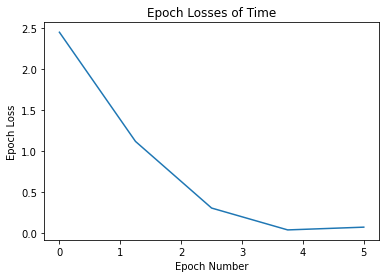

In [16]:
train_model(DWS_model, dataloader, num_epochs = 5, accumulation_steps = 4)


    Reconstruction Performance Statistics: 
    n: 25
    Max: 12.24
    Min: 6.15
    Avg: 9.3384
    St. Dev.: 1.0377463273844914
    


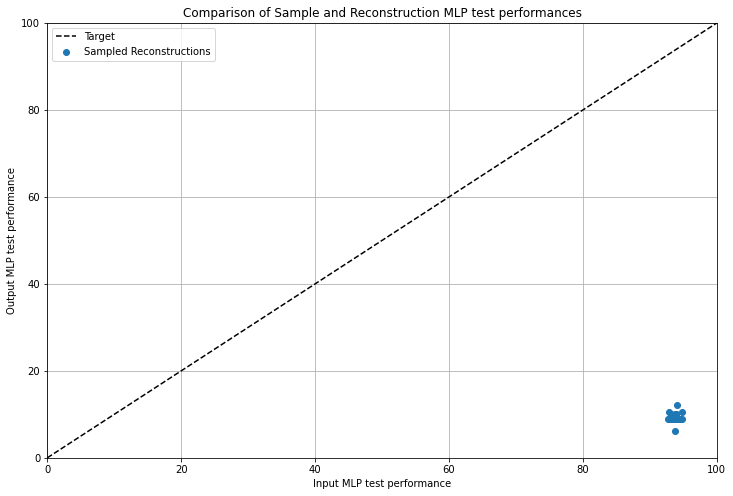

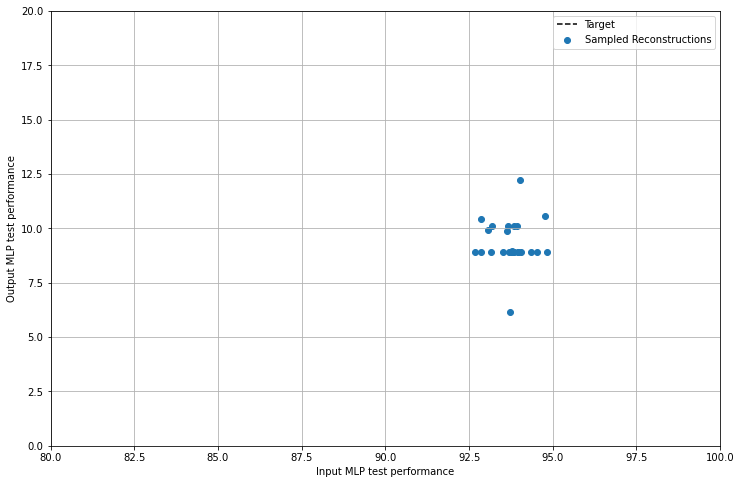

In [33]:
recon_test_pef_scatter(DWS_model, loader = dataloader, k = 25) 

Fresh Initialization After 1 epoch: 90.91
Model Recon After 1 epoch: 11.35


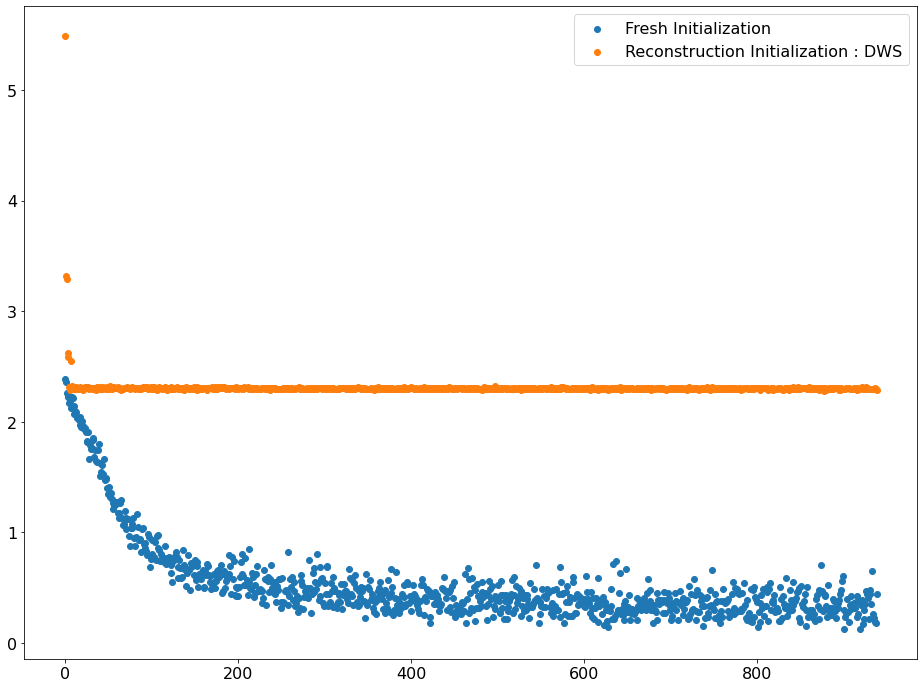

In [59]:
recon_retraining_optimizer_losses(DWS_model, f"DWS")

# Deep Sets (Perm. Invariant) Autoencoder:

## Linear Layers: 

In [28]:
# from https://github.com/manzilzaheer/DeepSets/blob/master/PopStats/model.py
# and from https://github.com/yassersouri/pytorch-deep-sets/blob/master/src/deepsets/networks.py
# Zaheer et. al. Deep Sets - perm. equivariant set ops
class DeepSetBridge(nn.Module):
    def __init__(self, in_features, weight_shapes, bias_shapes, set_features=7690//8, encoder_dims = [7690, 7690//4], decoder_dims = [7690//4, 7690]):
        super(DeepSetBridge, self).__init__()
        self.in_features = in_features
        self.set_features = set_features
        self.weight_shapes = weight_shapes
        self.bias_shapes = bias_shapes
        
        # only minor changes made: 
        # * removed hardcoded dims
        # * changed from ELU to LeakyReLU activation for speed
        self.encoder = nn.Sequential(
            nn.Linear(in_features, encoder_dims[0]),
            nn.LeakyReLU(0.1),
            nn.Linear(encoder_dims[0], encoder_dims[-1]),
            nn.LeakyReLU(0.1),
            nn.Linear(encoder_dims[-1], set_features)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(set_features, decoder_dims[0]),
            nn.LeakyReLU(0.1),
            nn.Linear(decoder_dims[0], decoder_dims[-1]),
            nn.LeakyReLU(0.1),
            nn.Linear(decoder_dims[-1], in_features),
        )
    
    def reset_parameters(self):
        for module in self.children():
            reset_op = getattr(module, "reset_parameters", None)
            if callable(reset_op):
                reset_op()
                
    def stack_parameters(self, x): 
        tensor_list = []
        for i in range(self.set_features):
            tensor_list.append(x)
        return torch.stack(tensor_list, dim = 1).squeeze()
    
    def reshape_output(self, tensor, weight_shapes, bias_shapes): 

        reshaped_weights = []
        for shape in weight_shapes:
            index = 0
            shape_list = []
            for i in range(tensor.shape[0]): 
                num_elements = torch.prod(torch.tensor(shape))
                shape_list.append( tensor[i, index:index+num_elements].view(shape).unsqueeze(-1))
            index += num_elements
            reshaped_weights.append(torch.stack(shape_list))

        reshaped_biases = []
        for shape in bias_shapes: 
            index = sum([torch.prod(torch.tensor(s)) for s in weight_shapes])
            shape_list = []
            for i in range(tensor.shape[0]): 
                num_elements = torch.prod(torch.tensor(shape))
                shape_list.append(tensor[i, index:index+num_elements].view(shape).unsqueeze(-1))
            index += num_elements
            reshaped_biases.append(torch.stack(shape_list))

        return Batch(tuple(reshaped_weights), tuple(reshaped_biases))
    
    
    def flatten_tuple(self, my_tuple):

        weights = torch.cat([my_tuple[0][i].flatten() for i in range(len(my_tuple[0]))])
        biases = torch.cat([my_tuple[1][i].flatten() for i in range(len(my_tuple[1]))])

        return torch.cat([weights, biases]).view(my_tuple[0][0].shape[0], -1)

    def add_noise(self, tensor, alpha): 
        noise = alpha * torch.randn_like(tensor)
        return tensor + noise
    
    def forward(self, input):
        """
        forward pass through Deep Sets 'bridge':
        input: tensor dim 4: [bs, layer input, layer output, 1]
        output: tensor dim 4: [bs, layer input, layer output, 1]
        
        Dims: 
        1.) [bs, layer in, layer out, 1] -> [bs, layer in * layer out]
        2.) [bs, layer in * layer out] -> [bs, set dim] -> [bs, 1]
        3.) [bs, 1]->[bs, set dim] done by stacking set dim copies of [bs, 1] on axis 1
        4.) [bs, set dim] -> [bs, layer in * layer out] -> [bs, layer in, layer out, 1]
        """
        
        x = self.flatten_tuple(input)
        x = self.encoder(x.unsqueeze(1)).squeeze()
#         print(f"X shape: {x.shape}")
        
        # Question - where to start z? 
        z = x.sum(dim=1, keepdim=True)
        
        z = self.stack_parameters(z)
        x = self.add_noise(z, alpha = 0.1)
        
        x = self.decoder(x.unsqueeze(1))
        out = self.reshape_output(x.squeeze(), self.weight_shapes, self.bias_shapes)
        return out, z



In [29]:
linear_deepsets_model = DeepSetBridge(in_features = 7690, weight_shapes = weight_shapes, bias_shapes = bias_shapes)
print(f"Model has: {count_parameters(linear_deepsets_model)} learnable params.")

Model has: 151554519 learnable params.


[0 25], train loss: 203.31845, epoch loss: 813.27380, epoch time: 19.913:  20%|██        | 1/5 [00:23<01:34, 23.64s/it]

Epoch 0 sample reconstruction accuracy: 7.39
Epoch 0 sample Tuple Loss: 430787.5625 *bad


[4 25], train loss: 8556.07812, epoch loss: 34224.31250, epoch time: 19.826: 100%|██████████| 5/5 [01:42<00:00, 20.41s/it]  


Training complete!


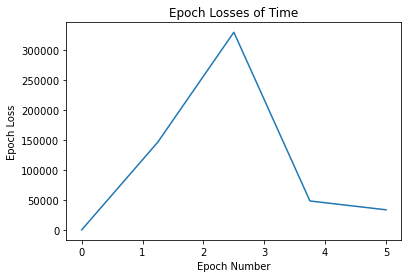

In [30]:
train_model(linear_deepsets_model, dataloader, num_epochs = 5, accumulation_steps = 4, learning_rate = 1e-3)


    Reconstruction Performance Statistics: 
    n: 25
    Max: 11.97
    Min: 10.28
    Avg: 10.356
    St. Dev.: 0.3294723053611641
    


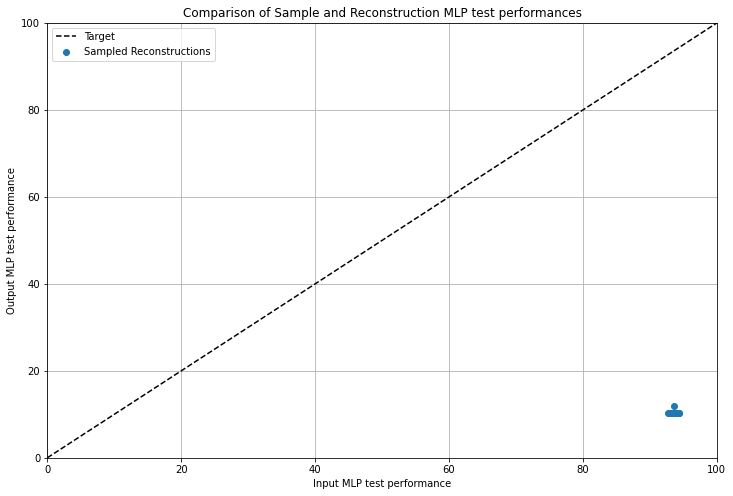

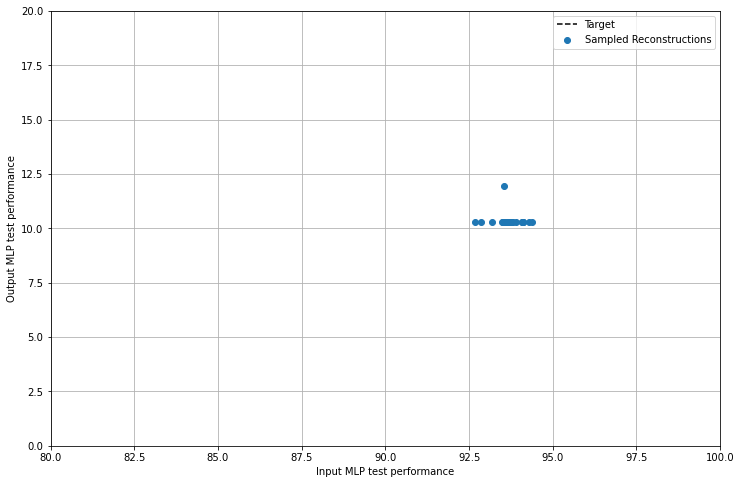

In [35]:
recon_test_pef_scatter(linear_deepsets_model, loader = dataloader, k = 25) 

Fresh Initialization After 1 epoch: 92.1
Model Recon After 1 epoch: 11.72


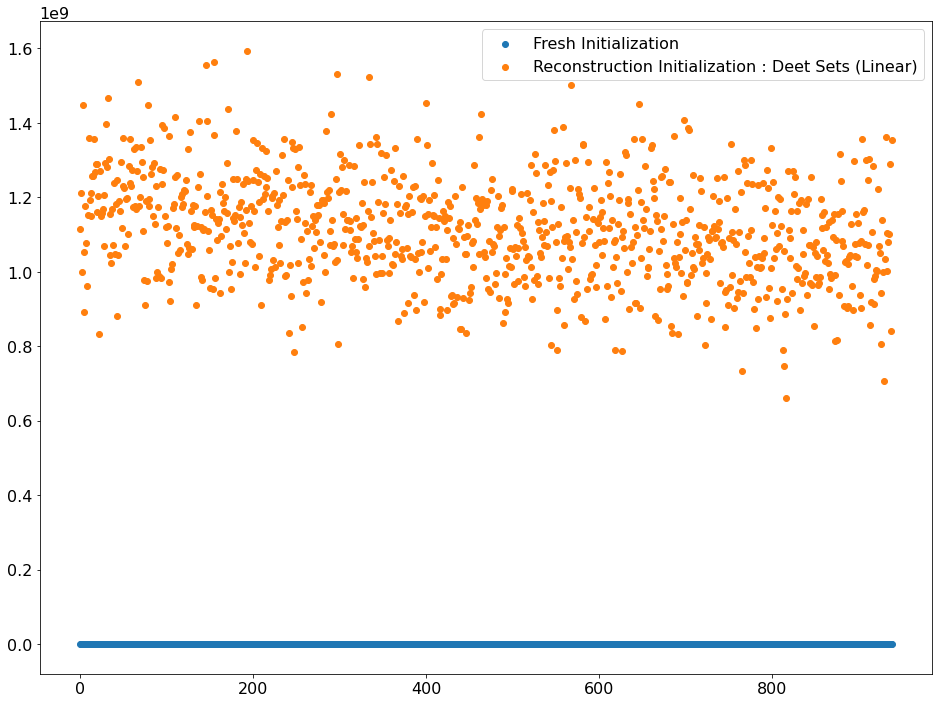

In [60]:
recon_retraining_optimizer_losses(linear_deepsets_model, f"Deet Sets (Linear)")

## Convolution: 

In [40]:
# from https://github.com/manzilzaheer/DeepSets/blob/master/PopStats/model.py
# and from https://github.com/yassersouri/pytorch-deep-sets/blob/master/src/deepsets/networks.py
# Zaheer et. al. Deep Sets - perm. equivariant set ops
class ResidualBlock(nn.Module): 
    def __init__(self, in_channels, hidden_channels): 
        super(ResidualBlock, self).__init__()
    
        self.act = nn.ELU() #nn.LeakyReLU(0.25)
 
        self.c1 = nn.Conv1d(in_channels, hidden_channels, 1, 1, padding = 0)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
        self.c2 = nn.Conv1d(hidden_channels, hidden_channels, 3, 1, padding = 1)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        
        self.c3 = nn.Conv1d(hidden_channels, in_channels, 1, 1, padding = 0)
        self.bn3 = nn.BatchNorm1d(in_channels)
        
    def forward(self, x): 
        residual = x
        x = self.act( self.bn1( self.c1(x) ) )
        x = self.act( self.bn2( self.c2(x) ) )
        x = self.act( self.bn3( self.c3(x) ) )
        return x + residual


class DeepSetBridge_C(nn.Module):
    def __init__(self, in_features, weight_shapes, bias_shapes, set_features = 960):
        super(DeepSetBridge_C, self).__init__()
        self.in_features = in_features
        self.weight_shapes = weight_shapes
        self.bias_shapes = bias_shapes
        self.set_features = 960
        
        # only minor changes made: 
        # * removed hardcoded dims
        # * changed from ELU to LeakyReLU activation for speed
        
        
        self.preprop = ResidualBlock(1, 1)
        self.postprop = ResidualBlock(1, 1)
    
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 1, 5, 2, padding = 1), 
            ResidualBlock(1, 1), 

            nn.Conv1d(1, 1, 4, 2), 
            ResidualBlock(1, 1), 

            nn.Conv1d(1, 1, 3, 2), 
            ResidualBlock(1, 1), 

        )

        self.decoder = nn.Sequential(            
            nn.ConvTranspose1d(1, 1, 3, 2, output_padding = 0), 
            ResidualBlock(1, 1), 

            nn.ConvTranspose1d(1, 1, 4, 2, output_padding = 0), 
            ResidualBlock(1, 1), 

            nn.ConvTranspose1d(1, 1, 4, 2, output_padding = 0), 
            ResidualBlock(1, 1), 

        )
    
    def reset_parameters(self):
        for module in self.children():
            reset_op = getattr(module, "reset_parameters", None)
            if callable(reset_op):
                reset_op()
                
    def stack_parameters(self, x): 
        tensor_list = []
        for i in range(self.set_features):
            tensor_list.append(x)
        return torch.stack(tensor_list, dim = 1).squeeze()
    
    def reshape_output(self, tensor, weight_shapes, bias_shapes): 

        reshaped_weights = []
        for shape in weight_shapes:
            index = 0
            shape_list = []
            for i in range(tensor.shape[0]): 
                num_elements = torch.prod(torch.tensor(shape))
                shape_list.append( tensor[i, index:index+num_elements].view(shape).unsqueeze(-1))
            index += num_elements
            reshaped_weights.append(torch.stack(shape_list))

        reshaped_biases = []
        for shape in bias_shapes: 
            index = sum([torch.prod(torch.tensor(s)) for s in weight_shapes])
            shape_list = []
            for i in range(tensor.shape[0]): 
                num_elements = torch.prod(torch.tensor(shape))
                shape_list.append(tensor[i, index:index+num_elements].view(shape).unsqueeze(-1))
            index += num_elements
            reshaped_biases.append(torch.stack(shape_list))

        return Batch(tuple(reshaped_weights), tuple(reshaped_biases))
    
    
    def flatten_tuple(self, my_tuple):

        weights = torch.cat([my_tuple[0][i].flatten() for i in range(len(my_tuple[0]))])
        biases = torch.cat([my_tuple[1][i].flatten() for i in range(len(my_tuple[1]))])

        return torch.cat([weights, biases]).view(my_tuple[0][0].shape[0], -1)

    def add_noise(self, tensor, alpha): 
        noise = alpha * torch.randn_like(tensor)
        return tensor + noise
    
    def forward(self, input):
        """
        forward pass through Deep Sets 'bridge':
        input: tensor dim 4: [bs, layer input, layer output, 1]
        output: tensor dim 4: [bs, layer input, layer output, 1]
        
        Dims: 
        1.) [bs, layer in, layer out, 1] -> [bs, layer in * layer out]
        2.) [bs, layer in * layer out] -> [bs, set dim] -> [bs, 1]
        3.) [bs, 1]->[bs, set dim] done by stacking set dim copies of [bs, 1] on axis 1
        4.) [bs, set dim] -> [bs, layer in * layer out] -> [bs, layer in, layer out, 1]
        """
        
        x = self.flatten_tuple(input).unsqueeze(1)
        x = self.preprop(x)
        x = self.encoder(x).squeeze()
#         print(f"X shape: {x.shape}")
        
        # Question - where to start z? 
        z = x.sum(dim=1, keepdim=True)
        
        z = self.stack_parameters(z)
        x = self.add_noise(z, alpha = 0.1)
        
        x = self.decoder(x.unsqueeze(1))
        x = self.postprop(x)
        out = self.reshape_output(x.squeeze(), self.weight_shapes, self.bias_shapes)
        return out, z


In [41]:
Conv_deepsets_model = DeepSetBridge_C(7690, weight_shapes, bias_shapes)
print(f"Model has: {count_parameters(Conv_deepsets_model)} learnable params.")

Model has: 141 learnable params.


[0 25], train loss: 259.37347, epoch loss: 1037.49390, epoch time: 7.988:  20%|██        | 1/5 [00:11<00:46, 11.58s/it]

Epoch 0 sample reconstruction accuracy: 11.35
Epoch 0 sample Tuple Loss: 2715.15576171875 *bad


[4 25], train loss: 35.87112, epoch loss: 143.48447, epoch time: 5.855: 100%|██████████| 5/5 [00:34<00:00,  6.98s/it]  

Training complete!


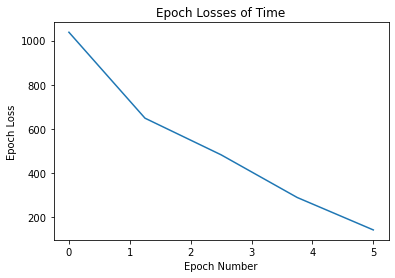

In [42]:
train_model(Conv_deepsets_model, dataloader, num_epochs = 5, accumulation_steps = 4, learning_rate = 1e-3)

In [43]:
# recon_test_pef_scatter(Conv_deepsets_model, loader = dataloader, k = 25) 

Fresh Initialization After 1 epoch: 92.1
Model Recon After 1 epoch: 12.25


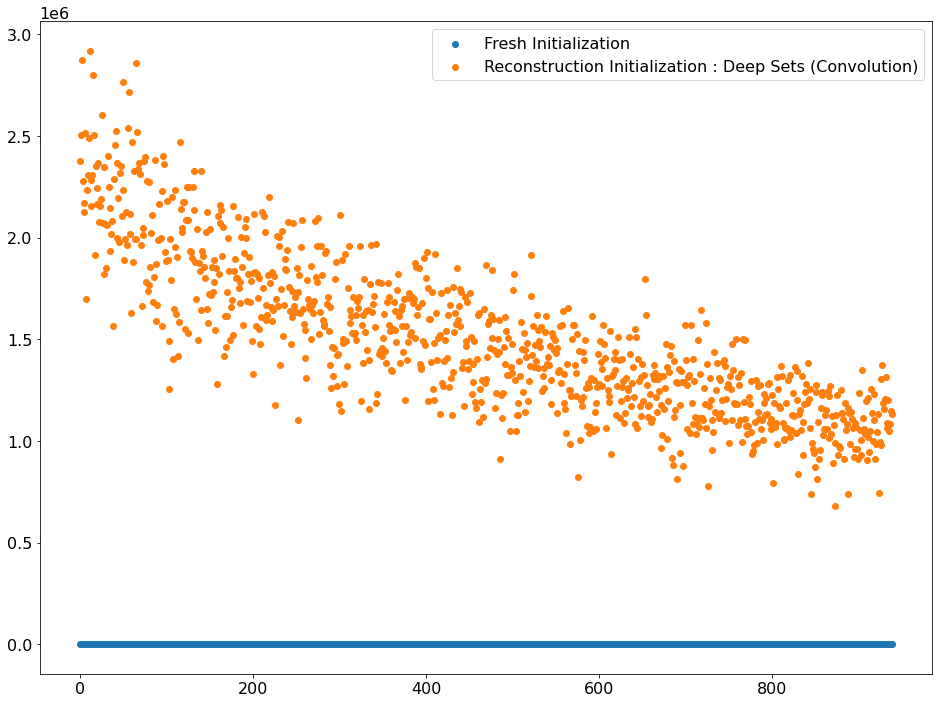

In [61]:
recon_retraining_optimizer_losses(Conv_deepsets_model, f"Deep Sets (Convolution)")

# Unconstrained Model (Convolution): 

In [49]:
class UnconstrainedModel(nn.Module):
    def __init__(self, weight_shapes, bias_shapes, batch_size = 32,  inputs = 7690, alpha = 0.1):
        super(UnconstrainedModel, self).__init__()
        
        self.weight_shapes = weight_shapes
        self.bias_shapes = bias_shapes
        self.batch_size = batch_size
        self.alpha = alpha
        
#         self.input_attn = nn.MultiheadAttention(inputs, 10)
        self.latent_attn = nn.MultiheadAttention(960, 10) # ew, hardcoded
        
        self.preprop = ResidualBlock(1, 1)
        self.postprop = ResidualBlock(1, 1)
    
        self.encoder = nn.Sequential(
            ResidualBlock(1, 1), 
            nn.Conv1d(1, 1, 5, 2, padding = 1), 
            ResidualBlock(1, 1), 

            nn.Conv1d(1, 1, 4, 2), 
            ResidualBlock(1, 1), 

            nn.Conv1d(1, 1, 3, 2), 
            ResidualBlock(1, 1), 

        )

        self.decoder = nn.Sequential(    
            nn.ConvTranspose1d(1, 1, 3, 2, output_padding = 0), 
            ResidualBlock(1, 1), 

            nn.ConvTranspose1d(1, 1, 4, 2, output_padding = 0), 
            ResidualBlock(1, 1), 

            nn.ConvTranspose1d(1, 1, 4, 2, output_padding = 0), 
            ResidualBlock(1, 1), 

        )

    def reshape_output(self, tensor, weight_shapes, bias_shapes): 
        """
        Function to reshape tensor [batch size, features] to a Batch(Tuple(weights), Tuple(biases))
        """
        reshaped_weights = []
        for shape in weight_shapes:
            index = 0
            shape_list = []
            for i in range(tensor.shape[0]): 
                num_elements = torch.prod(torch.tensor(shape))
                shape_list.append( tensor[i, index:index+num_elements].view(shape).unsqueeze(-1))
            index += num_elements
            reshaped_weights.append(torch.stack(shape_list))

        reshaped_biases = []
        for shape in bias_shapes: 
            index = sum([torch.prod(torch.tensor(s)) for s in weight_shapes])
            shape_list = []
            for i in range(tensor.shape[0]): 
                num_elements = torch.prod(torch.tensor(shape))
                shape_list.append(tensor[i, index:index+num_elements].view(shape).unsqueeze(-1))
            index += num_elements
            reshaped_biases.append(torch.stack(shape_list))

        return Batch(tuple(reshaped_weights), tuple(reshaped_biases))
    
    
    def flatten_tuple(self, my_tuple):
        """
        Function to flattent Batch(Tuple(weights), Tuple(biases)) to a tensor [batch size, features]
        """
        weights = torch.cat([my_tuple[0][i].flatten() for i in range(len(my_tuple[0]))])
        biases = torch.cat([my_tuple[1][i].flatten() for i in range(len(my_tuple[1]))])

        return torch.cat([weights, biases]).view(my_tuple[0][0].shape[0], -1)
    
    def sort_with_permutation(self, tensor):
        """
        Sorts a 2D tensor along the feature dimension and returns both the sorted tensor
        and the permutation indices.

        Args:
            tensor: Input tensor of shape [batch_size, features]

        Returns:
            sorted_tensor: The sorted tensor
            permutation_indices: Indices that would sort the original tensor
        """
        # Sort the tensor along dimension 1 (features)
        sorted_tensor, permutation_indices = torch.sort(tensor, dim=1)

        return sorted_tensor, permutation_indices

    def unsort_tensor(self, sorted_tensor, permutation_indices):
        """
        Restores the original ordering of a sorted tensor using permutation indices.

        Args:
            sorted_tensor: The sorted tensor of shape [batch_size, features]
            permutation_indices: Indices that were used to sort the original tensor

        Returns:
            original_tensor: The tensor with original ordering restored
        """
        batch_size, num_features = sorted_tensor.shape

        # Create indices for the batch dimension
        batch_indices = torch.arange(batch_size, device=sorted_tensor.device).unsqueeze(1).expand(-1, num_features)

        # Create a temporary tensor to hold the restored values
        restored_tensor = torch.zeros_like(sorted_tensor)

        # Place values back in their original positions
        restored_tensor.scatter_(1, permutation_indices, sorted_tensor)

        return restored_tensor

    def add_noise(self, tensor, alpha): 
        """
        Function to add scaled gaussian noise to a tensor. 
        Used in latent space for learning robust representations
        """
        noise = alpha * torch.randn_like(tensor)
        return tensor + noise
        
    def forward(self, x):
        
        # Flatten input Batch of MLPs 
        x = self.flatten_tuple(x)
#         print(f"X shape: {x.shape}")
#         print(f"X shape: {x.shape}")
#         attn_input, _ = self.input_attn(x, x, x)
#         x = x + attn_input
        x = self.preprop(x.unsqueeze(1))
        # Autoencoder

        # Apply sorting canonicalization
#         x, indicies = self.sort_with_permutation(x.squeeze())

        z = self.encoder(x).squeeze()
#         print(f"Z shape: {z.shape}")

        attn_z, _ = self.latent_attn(z, z, z)
        attn_z = attn_z.unsqueeze(1) + z.unsqueeze(1)
        x = self.decoder(attn_z + self.add_noise(attn_z, self.alpha)) #.squeeze()
#         print(x.shape)

        ae_out = self.postprop(x).squeeze()        
#         print(f"Out shape: {out.shape}")
        
        # Apply reverse sorting
#         sorted_out = self.unsort_tensor(ae_out, indicies)
        
        #  Reshape to Batch of MLPs   
        out = self.reshape_output(ae_out, self.weight_shapes, self.bias_shapes)
        return out, z 

In [50]:
Unconstrained_model = UnconstrainedModel(weight_shapes, bias_shapes) 
print(f"Model has: {count_parameters(Unconstrained_model)} learnable params.")

Model has: 3690395 learnable params.


[0 25], train loss: 0.38797, epoch loss: 1.55186, epoch time: 6.842:  20%|██        | 1/5 [00:10<00:41, 10.41s/it]

Epoch 0 sample reconstruction accuracy: 10.09
Epoch 0 sample Tuple Loss: 0.3943908214569092 *bad


[4 25], train loss: 0.13898, epoch loss: 0.55593, epoch time: 6.650: 100%|██████████| 5/5 [00:37<00:00,  7.43s/it]

Training complete!


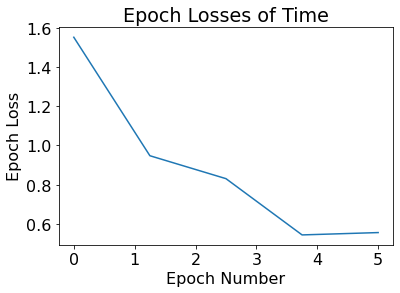

In [51]:
train_model(Unconstrained_model, dataloader, num_epochs = 5, accumulation_steps = 4, learning_rate = 1e-3)

In [ ]:
recon_test_pef_scatter(Unconstrained_model, loader = dataloader, k = 25) 

Fresh Initialization After 1 epoch: 90.38
Model Recon After 1 epoch: 40.37


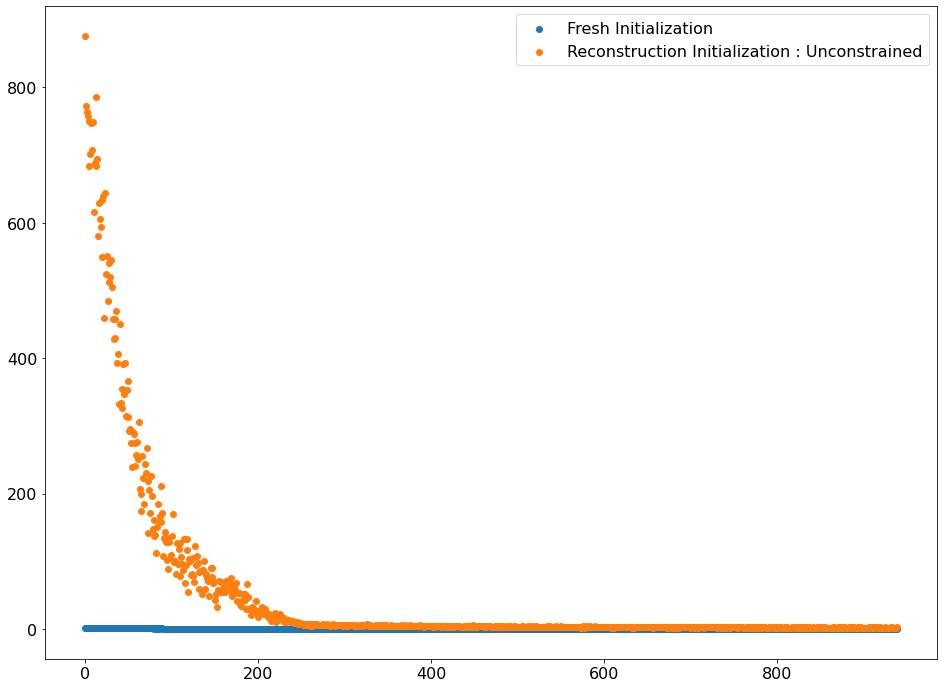

In [62]:
recon_retraining_optimizer_losses(Unconstrained_model, f"Unconstrained")

# Analysis here: 